In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import img_to_array
import sklearn
from sklearn.metrics import confusion_matrix
import itertools 
import random

In [2]:
PATH = 'D:/Colab Notebooks/'
PATH_IMG = PATH + 'connected_images/'

# Просмотр изображений

In [3]:
test = pd.read_csv(PATH + 'test.csv')
test_encoded = pd.read_csv(PATH + 'test_encoded.csv')
train = pd.read_csv(PATH + 'train.csv')
train_encoded = pd.read_csv(PATH + 'train_encoded.csv')

data = {'test': test, 'test_encoded': test_encoded, 'train': train, 'train_encoded': train_encoded}

In [4]:
train.head()

,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax
0,0,0007Date_01_08_2019.jpg,other,285,368,61,278
1,1,0013Date_01_08_2019.jpg,armature,187,550,101,253
2,2,0016Date_01_08_2019.jpg,armature,172,327,13,360
3,3,0019Date_01_08_2019.jpg,armature,19,267,162,237
4,4,0019Date_01_08_2019.jpg,armature,309,548,300,376


In [5]:
train_encoded.head()

,Image_name_Type,EncodedPixels
0,0007Date_01_08_2019.jpg_armature,1 1
1,0007Date_01_08_2019.jpg_other,43229 83 43933 83 44637 83 45341 83 46045 83 4...
2,0007Date_01_08_2019.jpg_wood,1 1
3,0013Date_01_08_2019.jpg_armature,71291 363 71995 363 72699 363 73403 363 74107 ...
4,0013Date_01_08_2019.jpg_other,1 1


In [6]:
print("В тестовом наборе {} объектов \nВ обучающем наборе {} объектов".format(len(test), len(train)))

В тестовом наборе 1688 объектов 
В обучающем наборе 2541 объектов


## Размер изображений

In [7]:
# посмотрим на размер исходных изображений (вдруг что-то нужно будет нормаировать)
# добавим в таблицу новый признак - размер изображения

pic_size = set()

test_img_size = []
train_img_size = []

for key in ['train', 'test']:
  for i, row in data[key].iterrows():
    im = cv2.imread(PATH_IMG + row['image_name'])
    height, width, _ = im.shape
    pic_size.add((height, width))
    if key == 'train':
      train_img_size.append((height, width))
    else:
      test_img_size.append((height, width))

train['Size'] = train_img_size
test['Size'] = test_img_size

print(pic_size)
test.head()

{(421, 704), (576, 704)}


,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax,Usage,Size
0,0,0000Date_01_08_2019.jpg,armature,173,403,84,380,Public,"(421, 704)"
1,1,0029Date_01_08_2019.jpg,armature,54,307,29,346,Public,"(421, 704)"
2,2,0049Date_01_08_2019.jpg,armature,510,576,71,202,Public,"(421, 704)"
3,3,0054Date_01_08_2019.jpg,armature,124,213,1,102,Public,"(421, 704)"
4,4,0057Date_01_08_2019.jpg,armature,158,579,80,278,Public,"(421, 704)"


In [8]:
#посмотрим сколько каких размеров

size_table_test = test.groupby(['Size'])['Size'].count().reset_index(name='Count')
size_table_test

,Size,Count
0,"(421, 704)",1686
1,"(576, 704)",2


Получается, в тестовом наборе данных присутствуют два изображения с нетипичным размером.

Удалим эти объекты

In [9]:
len_before = len(test)
test = test.loc[test['Size'] != (576, 704)]
len_after = len(test)
print("удалено {} объекта".format(len_before-len_after))

удалено 2 объекта


## Проверка пропусков

In [11]:
def check_empty(table):
  headers = table.columns
  count_null = pd.DataFrame(table[headers].isnull().sum())
  count_null = count_null.reset_index()
  count_null.rename(columns = {'index' : 'Column', 0 : 'Count_null'}, inplace = True) 
  
  return count_null

In [12]:
for key in data:
  print(key + ':')
  print(check_empty(data[key]), '\n\n')

test:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0
7       Usage           0
8        Size           0 


test_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0
2            Usage           0 


train:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0
7        Size           0 


train_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0 




Пропусков нет

## Распределение target

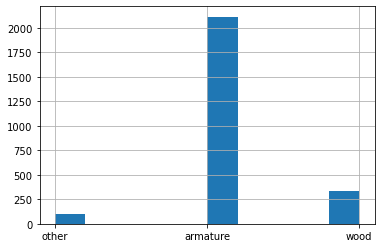

In [13]:
h = train['type'].hist()
fig = h.get_figure()

## Выделение объектов на изображениях

In [10]:
# соберем датасет для классификации

armature_all = []
wood_all = []
other_all = []
img_train = []

for i, row in train.iterrows():
    im = cv2.imread(PATH_IMG + row['image_name'])
    x_min, x_max, y_min, y_max = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    crop = im[y_min:y_max, x_min:x_max]
    img_train.append(crop)
    if row['type'] == 'armature':
        armature_all.append(crop)
    elif row['type'] == 'wood':
        wood_all.append(crop)
    else:
        other_all.append(crop)

armature_all = pd.DataFrame(armature_all, columns=['img'])
wood_all = pd.DataFrame(wood_all, columns=['img'])
other_all = pd.DataFrame(other_all, columns=['img'])

C:\Users\User\anaconda3\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
C:\Users\User\anaconda3\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
C:\Users\User\anaconda3\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

In [11]:
# Разделение выборки на train, test, split
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [12]:
# Каталог с набором данных
data_dir = PATH + 'test'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для тестирования
test_dir = 'test'
# Каталог с валидационными данными
val_dir = 'val'

In [17]:
# создадим подкаталоги

# def create_directory(dir_name):
#     if os.path.exists(dir_name):
#         shutil.rmtree(dir_name)
#     os.makedirs(dir_name)
#     os.makedirs(os.path.join(dir_name, "armature"))
#     os.makedirs(os.path.join(dir_name, "wood"))   
#     os.makedirs(os.path.join(dir_name, "other"))   

# Создание структуры каталогов для обучающего и тестового набора данных

# create_directory(train_dir)
# create_directory(test_dir)

In [13]:
# Скопируем изображения в подкаталоги
# 70% - обучающая выборка
# 15% - валидационная выборка
# 15% - тестовая выборка 

armature_train, armature_val, armature_test = train_validate_test_split(df=armature_all, train_percent=0.7, validate_percent=0.15)
wood_train, wood_val, wood_test = train_validate_test_split(df=wood_all, train_percent=0.7, validate_percent=0.15)
other_train, other_val, other_test = train_validate_test_split(df=other_all, train_percent=0.7, validate_percent=0.15)

In [14]:
# Проверим размеры полученных выборок
d = {'armature_train': armature_train, 'armature_val': armature_val, 'armature_test': armature_test,
          'wood_train': wood_train, 'wood_val': wood_val, 'wood_test': wood_test,
          'other_train': other_train, 'other_val': other_val, 'other_test': other_test}
i = 1
for key in d:
  print(f"{key}: {len(d[key])} ({len(d[key]) * 100.0 / len(eval( key[0 : key.find('_')] + '_all')) }%)", end='; ')
  if i % 3 == 0:
    print('\n')
  i += 1
  

armature_train: 1479 (69.99526739233318%); armature_val: 316 (14.955040227165169%); armature_test: 318 (15.049692380501657%); 

wood_train: 230 (69.6969696969697%); wood_val: 49 (14.848484848484848%); wood_test: 51 (15.454545454545455%); 

other_train: 68 (69.38775510204081%); other_val: 14 (14.285714285714286%); other_test: 16 (16.3265306122449%); 



In [20]:
# # Сохранить изображения в подкаталоги

# def save_images(data, dir, file_name):
#   i = 0
#   for i in range(len(data)):
#     cv2.imwrite(dir + '/' + file_name + str(i) + '.jpg', data[i])
    
#     save_images(armature_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/armature', 'armature')
# save_images(wood_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/wood', 'wood')
# save_images(other_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/other', 'other')

# save_images(armature_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/armature', 'armature')
# save_images(wood_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/wood', 'wood')
# save_images(other_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/other', 'other')

# save_images(armature_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/armature', 'armature')
# save_images(wood_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/wood', 'wood')
# save_images(other_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/other', 'other')

# Классификатор

In [15]:
# Размеры изображения
img_width, img_height = 150, 150

# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 5
# Размер мини-выборки
batch_size = 10

# Количество изображений для обучения
nb_train_samples_a = len(armature_train)
nb_train_samples_w = len(wood_train)
nb_train_samples_o = len(other_train)
# количетсво валидационных изображений
nb_val_samples_a = len(armature_val)
nb_val_samples_w = len(wood_val)
nb_val_samples_o = len(other_val)
# Количество изображений для тестирования
nb_test_samples_a = len(armature_test)
nb_test_samples_w = len(wood_test)
nb_test_samples_o = len(other_test)

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# отнормируем значение пикселей
datagen = ImageDataGenerator(rescale=1. / 255)

# Генератор данных для обучения на основе изображений из каталога
train_generator = datagen.flow_from_directory(
    PATH + 'train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1777 images belonging to 3 classes.


In [18]:
# Генератор данных для валидации на основе изображений из каталога

val_generator = datagen.flow_from_directory(
    PATH + 'val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 379 images belonging to 3 classes.


In [19]:
# Генератор данных для тестирования на основе изображений из каталога

test_generator = datagen.flow_from_directory(
    PATH + 'test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 385 images belonging to 3 classes.


In [20]:
# для демонстрации работы модели

pred_generator=datagen.flow_from_directory(PATH + 'val',
                                                 target_size=(img_width, img_height),
                                                 batch_size=100,
                                                 class_mode='categorical')

Found 379 images belonging to 3 classes.


## Обучение

In [28]:
# train_generator - генератор данных для обучения
# validation_data - генератор данных для проверки

model.fit_generator(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator)

Epoch 1/5


C:\Users\User\AppData\Local\Temp\ipykernel_12976\1052302795.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


178/178 [==============================] - 25s 136ms/step - loss: 0.6601 - accuracy: 0.8239 - val_loss: 0.4998 - val_accuracy: 0.8338
Epoch 2/5
178/178 [==============================] - 11s 61ms/step - loss: 0.5440 - accuracy: 0.8317 - val_loss: 0.4321 - val_accuracy: 0.8364
Epoch 3/5
178/178 [==============================] - 11s 62ms/step - loss: 0.4703 - accuracy: 0.8402 - val_loss: 0.4035 - val_accuracy: 0.8522
Epoch 4/5
178/178 [==============================] - 11s 64ms/step - loss: 0.4386 - accuracy: 0.8452 - val_loss: 0.4529 - val_accuracy: 0.8470
Epoch 5/5
178/178 [==============================] - 13s 74ms/step - loss: 0.3791 - accuracy: 0.8520 - val_loss: 0.3857 - val_accuracy: 0.8522


## Оценка на тестовом наборе

In [29]:
scores = model.evaluate_generator(test_generator)
print(f"Accuracy_test = {round(scores[1] * 100, 2)}")

C:\Users\User\AppData\Local\Temp\ipykernel_12976\446811477.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


Accuracy_test = 85.19


In [30]:
imgs, labels = pred_generator.next()
array_imgs = np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions = model.predict(imgs)
rounded_pred = np.asarray([np.round(i) for i in predictions])

4/4 [==============================] - 0s 26ms/step


In [25]:
categorical_test_labels = pd.DataFrame(labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(rounded_pred).idxmax(axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
 
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix


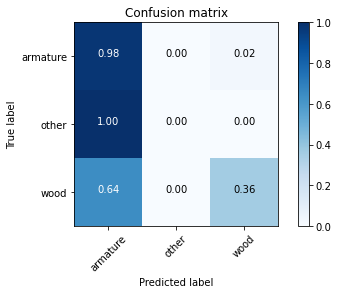

In [32]:
plot_confusion_matrix(confusion_matrix, ['armature', 'other', 'wood'], normalize=True)

In [33]:
# как закодировались метки
dict_ohe = {v:k for k, v in pred_generator.class_indices.items()} 
print(dict_ohe)

{0: 'armature', 1: 'other', 2: 'wood'}


C:\Users\User\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


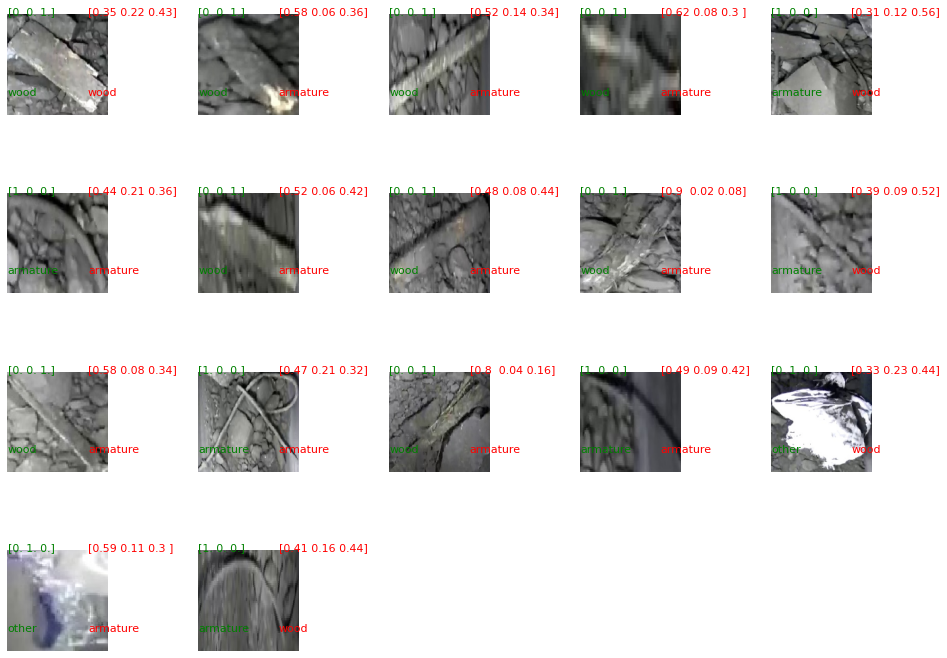

In [34]:
# посмотрим, какие изображения были распознаны неправильно

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if not np.array_equal(im[1], im[2])]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.9, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im = val[0]
    mas_true = val[2]
    mas_predict = val[3]
    class_true = dict_ohe[np.argmax(mas_true)]
    class_predict = dict_ohe[np.argmax(mas_predict)]
    plt.axis('off')
    plt.text(120, 0, np.round(mas_predict, 2), fontsize=11, color='red')
    plt.text(0, 0, mas_true, fontsize=11, color='green')
    plt.text(0, 120, class_true, fontsize=11, color='green')
    plt.text(120, 120, class_predict, fontsize=11, color='red')
    plt.imshow(im)

Как видно, в большинстве случаев классификатор путает дерево и арматуру

# Другой подход

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

In [149]:
# попробуем использовать дуругую модель и применим аугментауию
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [127]:
# print(len(armature_train['img'][0])  + len(other_train['img'][0]) + len(wood_train['img'][0]))
# train_img = list(armature_train['img'][0]) + list(other_train['img'][0]) + list(wood_train['img'][0])
# train_img = np.array(train_img)
# random.shuffle(train_img)

In [134]:
np.array(img_train).shape

C:\Users\User\AppData\Local\Temp\ipykernel_12976\474934637.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(img_train).shape


(2541,)

In [150]:
model = resnet_v1(input_shape=(img_width, img_height, 3), depth=20, num_classes=3)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [151]:
batch_size = 50
epochs = 15

model.fit_generator(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator)

Epoch 1/15


C:\Users\User\AppData\Local\Temp\ipykernel_12976\922837840.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


178/178 [==============================] - 111s 614ms/step - loss: 0.6783 - accuracy: 0.8469 - val_loss: 2.4129 - val_accuracy: 0.4776
Epoch 2/15
178/178 [==============================] - 112s 629ms/step - loss: 0.4726 - accuracy: 0.8998 - val_loss: 1.1425 - val_accuracy: 0.7625
Epoch 3/15
178/178 [==============================] - 114s 640ms/step - loss: 0.4365 - accuracy: 0.9133 - val_loss: 14.2859 - val_accuracy: 0.3879
Epoch 4/15
178/178 [==============================] - 115s 648ms/step - loss: 0.4434 - accuracy: 0.9043 - val_loss: 0.7231 - val_accuracy: 0.8522
Epoch 5/15
178/178 [==============================] - 111s 624ms/step - loss: 0.3974 - accuracy: 0.9178 - val_loss: 1.1283 - val_accuracy: 0.7414
Epoch 6/15
178/178 [==============================] - 114s 640ms/step - loss: 0.3778 - accuracy: 0.9223 - val_loss: 0.7230 - val_accuracy: 0.8285
Epoch 7/15
178/178 [==============================] - 110s 616ms/step - loss: 0.3587 - accuracy: 0.9263 - val_loss: 3.1904 - val_accur

In [177]:
loss =         [0.6783, 0.4726, 0.4365, 0.4434, 0.3974, 0.3778, 0.3587, 0.3157, 0.3158, 0.3072, 0.2724, 0.2494, 0.2528, 0.2365, 0.2394]
accuracy =     [0.8469, 0.8998, 0.9133, 0.9043, 0.9178, 0.9223, 0.9263, 0.9443, 0.9437, 0.9432, 0.9550, 0.9600, 0.9550, 0.9584, 0.9589]
val_loss =     [2.4129, 1.1425, 14.2859,0.7231, 1.1283, 0.7230, 3.1904, 0.7918, 0.5342, 0.9841, 0.7013, 0.8501, 3.6287, 0.7216, 0.7358]
val_accuracy = [0.4776, 0.7625, 0.3879, 0.8522, 0.7414, 0.8285, 0.4908, 0.8285, 0.8918, 0.8364, 0.8232, 0.8813, 0.5303, 0.8945, 0.8522]

epochs_arr = np.arange(1, epochs+1)

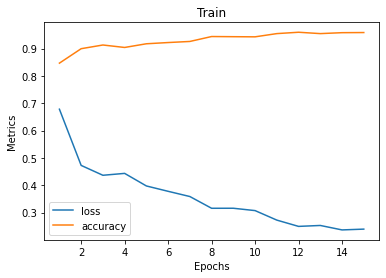

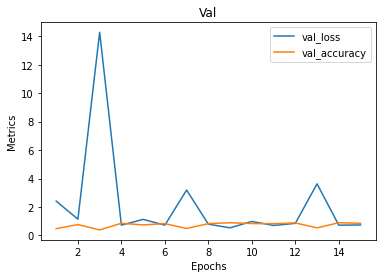

In [181]:
plt.plot(epochs_arr, loss, label='loss')
plt.plot(epochs_arr, accuracy, label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Train')
plt.show()

plt.plot(epochs_arr, val_loss, label='val_loss')
plt.plot(epochs_arr, val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Val')

plt.show()

In [205]:
# оставим 9 эпох
batch_size = 50
epochs = 9

model.fit_generator(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator)

C:\Users\User\AppData\Local\Temp\ipykernel_12976\2811804881.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/9
178/178 [==============================] - 106s 596ms/step - loss: 0.1979 - accuracy: 0.9730 - val_loss: 0.7265 - val_accuracy: 0.8522
Epoch 2/9
178/178 [==============================] - 105s 592ms/step - loss: 0.1896 - accuracy: 0.9769 - val_loss: 1.3126 - val_accuracy: 0.7784
Epoch 3/9
178/178 [==============================] - 106s 596ms/step - loss: 0.1957 - accuracy: 0.9764 - val_loss: 0.7966 - val_accuracy: 0.9050
Epoch 4/9
178/178 [==============================] - 106s 595ms/step - loss: 0.1732 - accuracy: 0.9803 - val_loss: 0.6379 - val_accuracy: 0.8918
Epoch 5/9
178/178 [==============================] - 106s 594ms/step - loss: 0.1881 - accuracy: 0.9786 - val_loss: 0.8511 - val_accuracy: 0.8760
Epoch 6/9
178/178 [==============================] - 106s 596ms/step - loss: 0.1895 - accuracy: 0.9814 - val_loss: 0.8648 - val_accuracy: 0.9077
Epoch 7/9
178/178 [==============================] - 105s 591ms/step - loss: 0.1547 - accuracy: 0.9899 - val_loss: 0.7780 - val_ac

In [206]:
scores = model.evaluate_generator(test_generator)
print(f"Accuracy_test = {round(scores[1] * 100, 2)}")

C:\Users\User\AppData\Local\Temp\ipykernel_12976\446811477.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


Accuracy_test = 90.91


In [207]:
imgs, labels = pred_generator.next()
array_imgs = np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions = model.predict(imgs)
rounded_pred = np.asarray([np.round(i) for i in predictions])

4/4 [==============================] - 1s 219ms/step


Normalized confusion matrix


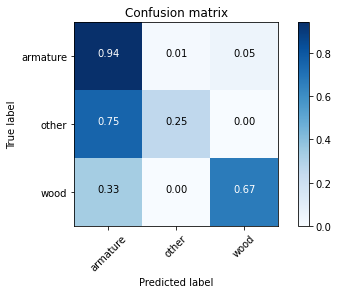

In [208]:
categorical_test_labels = pd.DataFrame(labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(rounded_pred).idxmax(axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(categorical_test_labels, categorical_preds)

plot_confusion_matrix(confusion_matrix, ['armature', 'other', 'wood'], normalize=True)

C:\Users\User\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


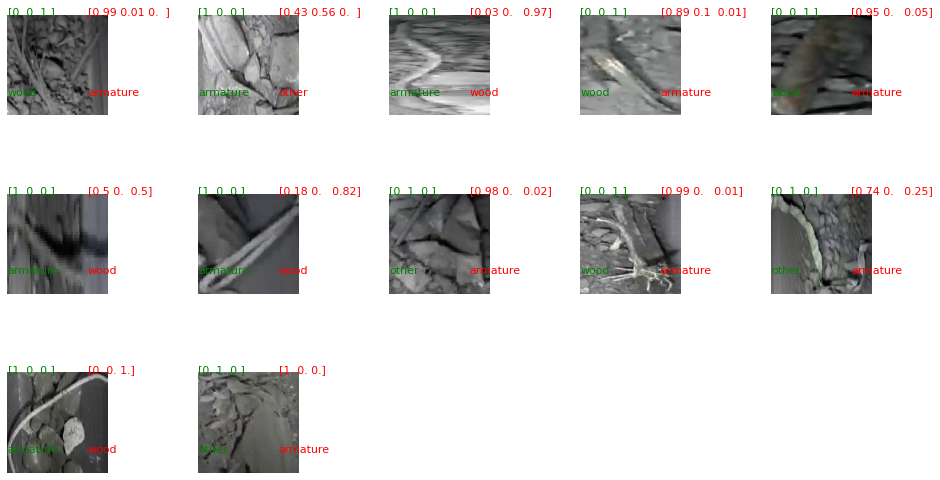

In [209]:
# посмотрим, какие изображения были распознаны неправильно

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if not np.array_equal(im[1], im[2])]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.9, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im = val[0]
    mas_true = val[2]
    mas_predict = val[3]
    class_true = dict_ohe[np.argmax(mas_true)]
    class_predict = dict_ohe[np.argmax(mas_predict)]
    plt.axis('off')
    plt.text(120, 0, np.round(mas_predict, 2), fontsize=11, color='red')
    plt.text(0, 0, mas_true, fontsize=11, color='green')
    plt.text(0, 120, class_true, fontsize=11, color='green')
    plt.text(120, 120, class_predict, fontsize=11, color='red')
    plt.imshow(im)

# Другой подход

In [21]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Dense, Dropout, Flatten 
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
import os
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2

def get_conv_model(dim = (150,150, 3)):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)    
    model = Sequential() 
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3))) 
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))  
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 30
batch_size = 32
model = get_conv_model(dim=(img_height, img_width, 3))

model_history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks = [early_stopping, model_checkpoint, lr_plat],
    validation_data=val_generator)

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_6168\3826084294.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/30
178/178 [==============================] - ETA: 0s - loss: 10.5471 - accuracy: 0.8267
Epoch 1: val_loss improved from inf to 9.10591, saving model to ModelWeights.h5
178/178 [==============================] - 27s 150ms/step - loss: 10.5471 - accuracy: 0.8267 - val_loss: 9.1059 - val_accuracy: 0.8338 - lr: 1.0000e-04
Epoch 2/30
178/178 [==============================] - ETA: 0s - loss: 7.9460 - accuracy: 0.8334
Epoch 2: val_loss improved from 9.10591 to 6.78967, saving model to ModelWeights.h5
178/178 [==============================] - 16s 92ms/step - loss: 7.9460 - accuracy: 0.8334 - val_loss: 6.7897 - val_accuracy: 0.8338 - lr: 1.0000e-04
Epoch 3/30
178/178 [==============================] - ETA: 0s - loss: 5.9177 - accuracy: 0.8351
Epoch 3: val_loss improved from 6.78967 to 5.05321, saving model to ModelWeights.h5
178/178 [==============================] - 17s 95ms/step - loss: 5.9177 - accuracy: 0.8351 - val_loss: 5.0532 - val_accuracy: 0.8522 - lr: 1.0000e-04
Epoch 4/30


Epoch 26/30
178/178 [==============================] - ETA: 0s - loss: 1.2033 - accuracy: 0.9257
Epoch 26: val_loss improved from 1.38222 to 1.33657, saving model to ModelWeights.h5
178/178 [==============================] - 17s 96ms/step - loss: 1.2033 - accuracy: 0.9257 - val_loss: 1.3366 - val_accuracy: 0.8813 - lr: 1.0000e-04
Epoch 27/30
178/178 [==============================] - ETA: 0s - loss: 1.1671 - accuracy: 0.9302
Epoch 27: val_loss did not improve from 1.33657
178/178 [==============================] - 18s 102ms/step - loss: 1.1671 - accuracy: 0.9302 - val_loss: 1.3449 - val_accuracy: 0.8918 - lr: 1.0000e-04
Epoch 28/30
178/178 [==============================] - ETA: 0s - loss: 1.1423 - accuracy: 0.9297
Epoch 28: val_loss improved from 1.33657 to 1.32620, saving model to ModelWeights.h5
178/178 [==============================] - 17s 97ms/step - loss: 1.1423 - accuracy: 0.9297 - val_loss: 1.3262 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 29/30
178/178 [===================

In [23]:
scores = model.evaluate_generator(test_generator)
print(f"Accuracy_test = {round(scores[1] * 100, 2)}")

C:\Users\User\AppData\Local\Temp\ipykernel_6168\446811477.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


Accuracy_test = 91.69


4/4 [==============================] - 0s 40ms/step
Normalized confusion matrix


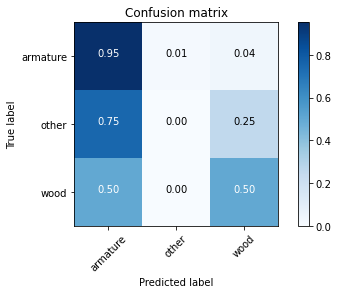

In [26]:
imgs, labels = pred_generator.next()
array_imgs = np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions = model.predict(imgs)
rounded_pred = np.asarray([np.round(i) for i in predictions])

categorical_test_labels = pd.DataFrame(labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(rounded_pred).idxmax(axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(categorical_test_labels, categorical_preds)

plot_confusion_matrix(confusion_matrix, ['armature', 'other', 'wood'], normalize=True)

In [60]:
# val_accuracy.index(max(val_accuracy))

25

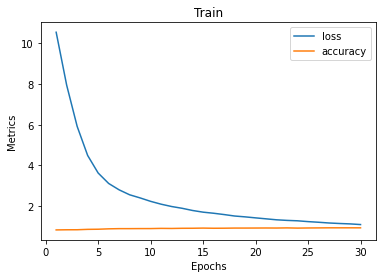

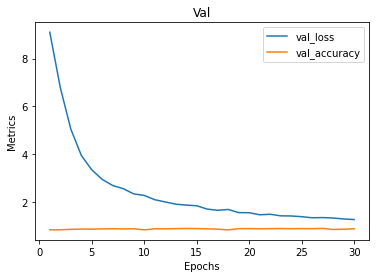

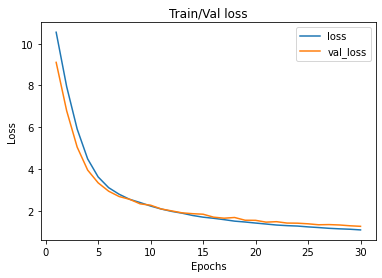

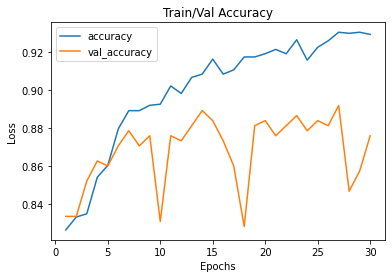

In [27]:
loss = model_history.history["loss"]
accuracy = model_history.history["accuracy"]
val_loss = model_history.history["val_loss"]
val_accuracy = model_history.history["val_accuracy"]

epochs_arr = np.arange(1, len(loss)+1)

plt.plot(epochs_arr, loss, label='loss')
plt.plot(epochs_arr, accuracy, label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Train')
plt.show()

plt.plot(epochs_arr, val_loss, label='val_loss')
plt.plot(epochs_arr, val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Val')
plt.show()

plt.plot(epochs_arr, loss, label='loss')
plt.plot(epochs_arr, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val loss')
plt.show()

plt.plot(epochs_arr, accuracy, label='accuracy')
plt.plot(epochs_arr, val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Accuracy')

plt.show()

# Object Detection

In [32]:
from keras.preprocessing import image 
from keras.utils import load_img, img_to_array

def get_image_value(path, dim): 
    '''This function will read an image and convert to a specified version and resize depending on which algorithm is being used. '''
    img = load_img(path, target_size = dim)
    img = img_to_array(img)
    return img/255

def get_img_array(img_paths, dim): 
    '''This fucntion takes a list of image paths and returns the np array corresponding to each image.  It also takes the dim and whether edge is specified in order to pass it to another function to apply these parameters.  This function uses get_image_value to perform these operations'''
    final_array = []
    from tqdm import tqdm
    for path in tqdm(img_paths):
        img = get_image_value(path, dim)
        final_array.append(img)
    final_array = np.array(final_array)  
    return final_array

def non_max_suppression(boxes, overlapThresh= .5):
    '''This image was taken from PyImageSearch... again cannot thank that guy enough'''
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1, yy1, xx2, yy2 = np.maximum(x1[i], x1[idxs[:last]]), np.maximum(y1[i], y1[idxs[:last]]), np.minimum(x2[i], x2[idxs[:last]]), np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w, h = np.maximum(0, xx2 - xx1 + 1), np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return pick

def get_img_prediction_bounding_box(path, model, dim):
    '''This function will create a bounding box over what it believes is a weapon given the image path, dimensions, and model used to detect the weapon.  Dimensions can be found within the Var.py file.  This function is still being used as I need to apply non-max suppresion to create only one bounding box'''
    img = get_image_value(path, dim)   
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    pred = model.predict(img)[0]
    category_dict = {0: 'armature', 1: 'other', 2: 'wood'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    print(f'{path}\t\tPrediction: {cat}\t{int(pred.max()*100)}% Confident')

    #speed up cv2
    cv2.setUseOptimized(True)
    cv2.setNumThreads(10) #change depending on your computer
    img = cv2.imread(path)
    clone = img.copy() 
    clone2 = img.copy()
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()

    rects = ss.process() 
    windows = []
    locations = []
    print(f'Creating Bounding Boxes for {path}')
    for x, y, w,h in rects[:1001]: 
        startx, starty, endx, endy = x, y, x+w, y+h 
        roi = img[starty:endy, startx:endx]
        roi = cv2.resize(roi, dsize =dim, interpolation = cv2.INTER_CUBIC)
        windows.append(roi)
        locations.append((startx, starty, endx, endy))
    windows = np.array(windows)
    windows = windows.reshape(windows.shape[0], windows.shape[1], windows.shape[2], 3)
    windows = np.array(windows)
    locations = np.array(locations)
    predictions = model.predict(windows)
    nms = non_max_suppression(locations)
    bounding_cnt = 0
    for idx in nms:
        if np.argmax(predictions[idx]) != cat_index: 
            continue
        startx, starty, endx, endy = locations[idx]
        cv2.rectangle(clone, (startx, starty), (endx, endy), (0,0,255), 2)
        text = f'{category_dict[np.argmax(predictions[idx])]}: {int(predictions[idx].max()*100)}%'
        cv2.putText(clone, text, (startx, starty+15), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,0),2)
        bounding_cnt += 1

    if bounding_cnt == 0: 
        pred_idx= [idx for idx, i in enumerate(predictions) if np.argmax(i) == cat_index]
        cat_locations = np.array([locations[i] for i in pred_idx])
        nms = non_max_suppression(cat_locations)
        if len(nms)==0:
            cat_predictions = predictions[:,cat_index]
            pred_max_idx = np.argmax(cat_predictions)
            pred_max = cat_predictions[pred_max_idx]
            pred_max_window = locations[pred_max_idx]
            startx, starty, endx, endy = pred_max_window
            cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,0,255),2)
            text = f'{category_dict[cat_index]}: {int(pred_max*100)}%'
            cv2.putText(clone, text, (startx, starty+15), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,0),2)
        for idx in nms: 
            startx, starty, endx, endy = cat_locations[idx]
            cv2.rectangle(clone, (startx, starty), (endx, endy), (0,0,255), 2)
            text = f'{category_dict[np.argmax(predictions[pred_idx[idx]])]}: {int(predictions[pred_idx[idx]].max()*100)}%'
            cv2.putText(clone, text, (startx, starty+15), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,0),2)        
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    cv2.imshow(f'Test', np.hstack([clone, clone2]))
    cv2.waitKey(0)
    ss.clear()
    return predictions

In [42]:
#NORMAL MODEL
dim = (img_height, img_width, 3)    
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights.h5') #path to the model weights
test_folder = "C:/Users/User/Desktop/folder" #folder where you will put your images to test
predictions = []
for idx, i in enumerate([i for i in os.listdir(test_folder) if i != 'ipynb_checkpoints']):
    img_path = f'{test_folder}/{i}'
    pred = get_img_prediction_bounding_box(img_path, normal_model, dim = (img_height, img_width))
    predictions.append(pred)

1/1 [==============================] - 0s 65ms/step


C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


pred = [0.82243615 0.15238926 0.02517457]
C:/Users/User/Desktop/folder/0000Date_01_08_2019.jpg		Prediction: armature	82% Confident
Creating Bounding Boxes for C:/Users/User/Desktop/folder/0000Date_01_08_2019.jpg
32/32 [==============================] - 3s 94ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Lime

Creating Lime Image for 0000Date_01_08_2019.jpg


  0%|          | 0/3500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


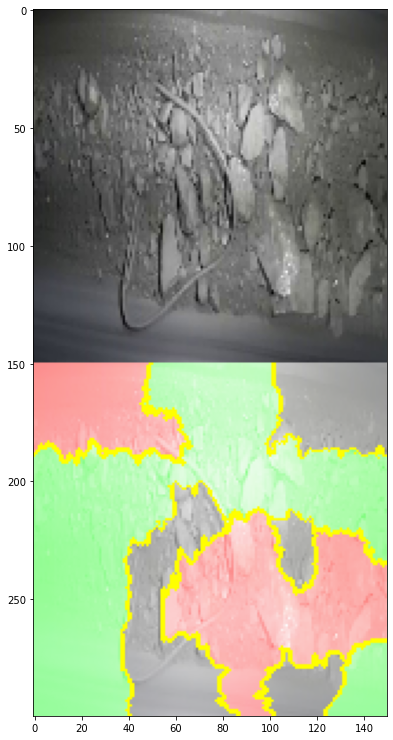

In [41]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_lime_predictions(base_folder, model, dim, iter = 3500): 
    '''This function will take a base folder containing images that will be run through the LIME package.  It will save the figure if a 
    save_name is passed. '''
    lime_images = [] 
    original_images = []
    for file in os.listdir(base_folder): 
        print(f'Creating Lime Image for {file}')
        path = f'{base_folder}/{file}'
        img = get_image_value(path, dim)
        original_images.append(img)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(img, model.predict, top_labels = 5, hide_color = 0, num_samples = iter)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False, num_features = 10, 
                                                   hide_rest = False)
        lime_img = mark_boundaries(temp/2 + .5, mask)
        lime_images.append(lime_img)
    lime_images = np.hstack(lime_images)
    original_images = np.hstack(original_images)
    joined_images = np.vstack([original_images, lime_images])
    plt.figure(figsize = (13,13))
    plt.imshow(joined_images)
   

dim = (img_height, img_width, 3)
model = get_conv_model(dim)
model.load_weights('ModelWeights.h5')
get_lime_predictions("C:/Users/User/Desktop/folder", model, dim)